0. IMPORTS

In [0]:
%pip install openpyxl

Python interpreter will be restarted.
Requirement already satisfied: openpyxl in /local_disk0/.ephemeral_nfs/envs/pythonEnv-ce301ece-da66-4dff-8816-866ee53551df/lib/python3.8/site-packages (3.1.5)
Requirement already satisfied: et-xmlfile in /local_disk0/.ephemeral_nfs/envs/pythonEnv-ce301ece-da66-4dff-8816-866ee53551df/lib/python3.8/site-packages (from openpyxl) (2.0.0)
Python interpreter will be restarted.

1. AZURE DATA LAKE STORAGE CONFIG KEY FROM VAULTS

In [0]:
storage_account_name = "gasprojectsadl"
raw_data_container = "raw-data"
processed_data_container = "processed-data"

storage_key = dbutils.secrets.get(scope="gas-project-scope", key="gasprojectsadl-key")
spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.dfs.core.windows.net",
    storage_key
)
print("Configuration complete. Databricks is now connected to your Azure Data Lake.")

Configuration complete. Databricks is now connected to your Azure Data Lake.

2. FILE PATH AND LIBRARIES

In [0]:

base_path = f"abfss://{raw_data_container}@{storage_account_name}.dfs.core.windows.net/EA_LDZ_Raw_Data"

demand_file_path = f"{base_path}/EA_Demand_Actual.xlsx"
cv_file_path = f"{base_path}/EA_CV.xlsx"
cwv_file_path = f"{base_path}/EA_CWV.xlsx"
sap_price_file_path = f"{base_path}/SAP_Price.xlsx"
temp_file_path = f"{base_path}/Temperature.xlsx"

print("File paths defined.")

File paths defined.

3. PROCESSING DEMAND DATA

In [0]:
import pandas as pd
from pyspark.sql.functions import col

pd_demand_path = f"/dbfs/mnt/{raw_data_container}/EA_LDZ_Raw_Data/EA_Demand_Actual.xlsx"

try:
    dbutils.fs.mount(
        source=f"wasbs://{raw_data_container}@{storage_account_name}.blob.core.windows.net/",
        mount_point=f"/mnt/{raw_data_container}",
        extra_configs={f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_key},
    )
except Exception as e:
    if "Directory already mounted" in str(e):
        print("Directory is already mounted.")
    else:
        raise e

sheet_map_demand = {'D+1': 'Demand_D+1', 'D+6': 'Demand_D+6'}
cleaned_demand_dfs = []
for sheet, col_name in sheet_map_demand.items():
    df = pd.read_excel(pd_demand_path, sheet_name=sheet)
    df['Applicable For'] = pd.to_datetime(df['Applicable For'])
    df = df[['Applicable For', 'Value']].rename(columns={'Value': col_name})
    df.set_index('Applicable For', inplace=True)
    cleaned_demand_dfs.append(df)

pd_final_demand = pd.concat(cleaned_demand_dfs, axis=1, join='outer').sort_index()
df_demand = spark.createDataFrame(pd_final_demand.reset_index())

print("Demand data processed successfully.")
display(df_demand)

Directory is already mounted.
Demand data processed successfully.

Applicable For,Demand_D+1,Demand_D+6
2020-07-20T00:00:00.000+0000,4.22952,4.22952
2020-07-21T00:00:00.000+0000,4.27536,4.27536
2020-07-22T00:00:00.000+0000,4.04954,4.04954
2020-07-23T00:00:00.000+0000,3.92413,3.92413
2020-07-24T00:00:00.000+0000,3.87348,3.87348
2020-07-25T00:00:00.000+0000,3.79348,3.79348
2020-07-26T00:00:00.000+0000,3.75835,3.75835
2020-07-27T00:00:00.000+0000,4.09257,4.09257
2020-07-28T00:00:00.000+0000,4.3298,4.3298
2020-07-29T00:00:00.000+0000,4.25053,4.25053


4. PROCESSING CV, CWV , SAP and Temperature Data

In [0]:
def process_single_sheet_excel(file_name, new_col_name, sheet_name='Sheet1'):
    pd_path = f"/dbfs/mnt/{raw_data_container}/EA_LDZ_Raw_Data/{file_name}"
    df = pd.read_excel(pd_path, sheet_name=sheet_name)
    df['Applicable For'] = pd.to_datetime(df['Applicable For'])
    df = df[['Applicable For', 'Value']].rename(columns={'Value': new_col_name})
    df.set_index('Applicable For', inplace=True)
    return spark.createDataFrame(df.reset_index())

def process_multi_sheet_excel(file_name, sheet_map):
    pd_path = f"/dbfs/mnt/{raw_data_container}/EA_LDZ_Raw_Data/{file_name}"
    cleaned_dfs = []
    for sheet, col_name in sheet_map.items():
        df = pd.read_excel(pd_path, sheet_name=sheet)
        df['Applicable For'] = pd.to_datetime(df['Applicable For'])
        df = df[['Applicable For', 'Value']].rename(columns={'Value': col_name})
        df.set_index('Applicable For', inplace=True)
        cleaned_dfs.append(df)
    pd_final = pd.concat(cleaned_dfs, axis=1, join='outer').sort_index()
    return spark.createDataFrame(pd_final.reset_index())

df_cv = process_single_sheet_excel("EA_CV.xlsx", "Calorific_Value")
print("CV data processed.")

sheet_map_cwv = {'EA_CWV_D-1': 'CWV_D-1', 'EA_CWV_D': 'CWV_D', 'EA_CWV_D+1': 'CWV_D+1'}
df_cwv = process_multi_sheet_excel("EA_CWV.xlsx", sheet_map_cwv)
print("CWV data processed.")

sheet_map_sap = {'SAP_Actual_Day': 'SAP_Actual_Day', 'SAP_Highest_18': 'SAP_Highest_18', 'SAP_7D_RAVG': 'SAP_7D_RAVG', 'SAP_30D_RAVG': 'SAP_30D_RAVG'}
df_sap = process_multi_sheet_excel("SAP_Price.xlsx", sheet_map_sap)
print("SAP Price data processed.")

sheet_map_temp = {'Ac_D+1': 'Temp_Ac_D+1(C)', 'Fo_D': 'Temp_Fo_D(C)', 'Fo_D-1': 'Temp_Fo_D-1(C)', 'SN_D': 'Temp_SN_D(C)', 'SN_D+1': 'Temp_SN_D+1(C)', 'SN_D-1': 'Temp_SN_D-1(C)'}
df_temp = process_multi_sheet_excel("Temperature.xlsx", sheet_map_temp)
print("Temperature data processed.")

CV data processed.
CWV data processed.
SAP Price data processed.
Temperature data processed.

5. OUTER JOIN ALL TO MASTER DF

In [0]:
from pyspark.sql.functions import to_date, date_format

master_df_raw = df_demand \
    .join(df_cv, on='Applicable For', how='outer') \
    .join(df_cwv, on='Applicable For', how='outer') \
    .join(df_sap, on='Applicable For', how='outer') \
    .join(df_temp, on='Applicable For', how='outer')

master_df_formatted = master_df_raw.withColumn("Applicable For", to_date(col("Applicable For")))

master_df_final = master_df_formatted.orderBy('Applicable For')

print("All data has been merged and formatted.")
print("Displaying the final master DataFrame (nulls will appear as blank):")
display(master_df_final)

All data has been merged and formatted.
Displaying the final master DataFrame (nulls will appear as blank):

Applicable For,Demand_D+1,Demand_D+6,Calorific_Value,CWV_D-1,CWV_D,CWV_D+1,SAP_Actual_Day,SAP_Highest_18,SAP_7D_RAVG,SAP_30D_RAVG,Temp_Ac_D+1(C),Temp_Fo_D(C),Temp_Fo_D-1(C),Temp_SN_D(C),Temp_SN_D+1(C),Temp_SN_D-1(C)
2020-05-25,null,null,null,null,null,null,null,null,null,null,14.9,14.9,14.9,13.7,13.7,13.7
2020-05-26,null,null,null,null,null,null,null,null,null,null,14.9,15.2,15.2,13.7,13.7,13.7
2020-05-27,null,null,null,null,null,null,null,null,null,null,15.3,15.2,15.3,13.8,13.8,13.8
2020-05-28,null,null,null,null,null,null,null,null,null,null,15.4,15.4,15.3,13.9,13.9,13.8
2020-05-29,null,null,null,null,null,null,null,null,null,null,15.5,15.5,15.5,13.9,13.9,13.9
2020-05-30,null,null,null,null,null,null,null,null,null,null,15.5,15.5,15.5,14.0,14.0,14.0
2020-05-31,null,null,null,null,null,null,null,null,null,null,15.6,15.6,15.6,14.1,14.1,14.1
2020-07-20,4.22952,4.22952,39.7,16.28,16.25,16.25,0.4272,2.0627,0.4254,0.4679,15.0,15.1,null,15.5,15.5,null
2020-07-21,4.27536,4.27536,39.5,16.17,16.23,16.23,0.4458,2.0627,0.428,0.4665,15.1,15.1,15.0,15.5,15.5,15.5
2020-07-22,4.04954,4.04954,39.6,16.42,16.56,16.57,0.4267,2.0627,0.433,0.4661,15.3,15.3,15.3,15.5,15.5,15.5


6. SAVE MASTER DF TO PROCESSED DATA

In [0]:
from pyspark.sql import SparkSession
from pyspark.dbutils import DBUtils

temp_output_path = f"abfss://{processed_data_container}@{storage_account_name}.dfs.core.windows.net/tmp_final_csv"

final_output_path = f"abfss://{processed_data_container}@{storage_account_name}.dfs.core.windows.net/final_ea_ldz_master_csv/master_ea_ldz.csv"

master_df_final.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .option("nullValue", "") \
    .csv(temp_output_path)

dbutils = DBUtils(SparkSession.builder.getOrCreate())
fs = dbutils.fs

files = fs.ls(temp_output_path)
part_file = [f.path for f in files if f.name.startswith("part-") and f.name.endswith(".csv")][0]

fs.mv(part_file, final_output_path)

fs.rm(temp_output_path, recurse=True)

print(f"Successfully saved as: {final_output_path}")


Successfully saved as: abfss://processed-data@gasprojectsadl.dfs.core.windows.net/final_ea_ldz_master_csv/master_ea_ldz.csv

7. CORRELATION MATRIX

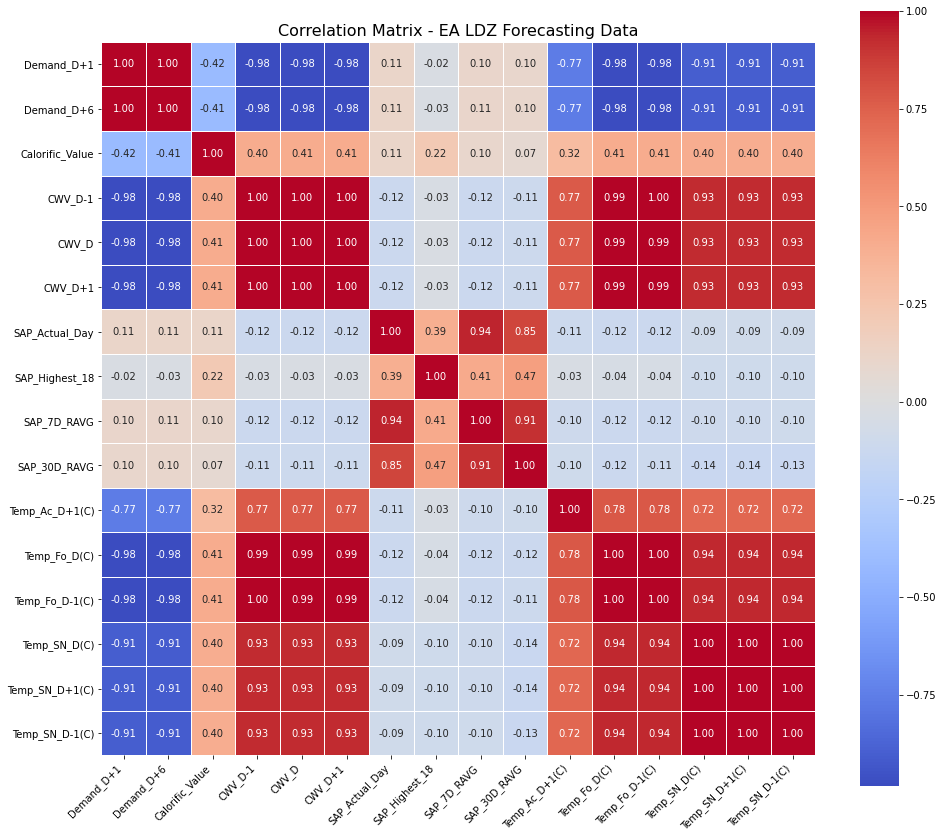

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_corr_pandas = master_df_final.toPandas()
df_corr_pandas.set_index('Applicable For', inplace=True)
df_numeric = df_corr_pandas.select_dtypes(include=['number']).fillna(method='ffill')

corr_matrix = df_numeric.corr()

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,linewidths=0.5)
plt.title("Correlation Matrix - EA LDZ Forecasting Data", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

8. TRENDS ANALYSIS

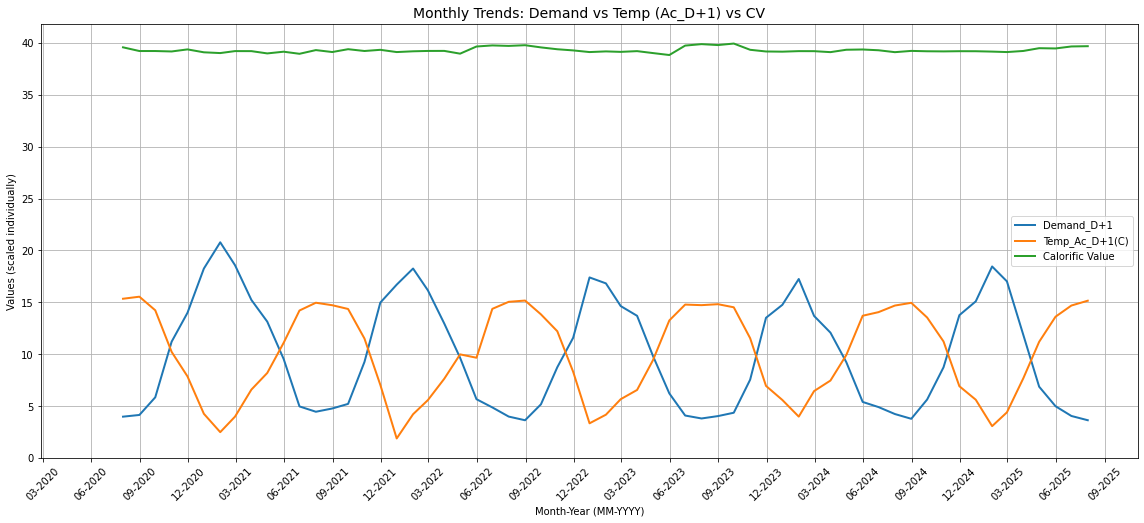

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_plot_pandas = master_df_final.toPandas()
df_plot_pandas['Applicable For'] = pd.to_datetime(df_plot_pandas['Applicable For'])
df_plot_pandas.set_index('Applicable For', inplace=True)
plot_df = df_plot_pandas[['Demand_D+1', 'Temp_Ac_D+1(C)', 'Calorific_Value']]
monthly_df = plot_df.resample('M').mean()

plt.figure(figsize=(16, 7))
plt.plot(monthly_df.index, monthly_df['Demand_D+1'], label='Demand_D+1', linewidth=2)
plt.plot(monthly_df.index, monthly_df['Temp_Ac_D+1(C)'], label='Temp_Ac_D+1(C)', linewidth=2)
plt.plot(monthly_df.index, monthly_df['Calorific_Value'], label='Calorific Value', linewidth=2)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.title('Monthly Trends: Demand vs Temp (Ac_D+1) vs CV', fontsize=14)
plt.xlabel('Month-Year (MM-YYYY)')
plt.ylabel('Values (scaled individually)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()